### Run this cell first which will load in required functions from helper.py

In [1]:
%matplotlib notebook
%run helper_fx.py

Importing required functions...
Initializing session...


### Change this to the filename you want to analyse and set box 1 or box 2

In [2]:
file = 'R:\\DA_and_Reward\\gc214\\dPP1\\tdt files\\08042019\\Giulia-190408-101326'
file = 'C:\\Raw Data Files\\Giulia-190408-101326' # rats 3 and 4, box 1 great

#sessions from Tuesday, 9th April
file = 'C:\\Raw Data Files\\Giulia-190409-115508' # box 2 rubbish, maybe a tiny thing in box 1
file = 'C:\\Raw Data Files\\Giulia-190409-105804' # maybe something box 1, nothing box 2
file = 'C:\\Raw Data Files\\Giulia-190409-100857' # box 1 good, box 2 maybe a bit
file = 'C:\\Raw Data Files\\Giulia-190409-091106' # box 1 and 2 probably rubbish (but box 2 noisy so maybe something)

file = 'C:\\Raw Data Files\\Giulia-190408-101326' # rats 3 and 4, box 1 great

file = 'C:\\Raw Data Files\\Giulia-190412-101808' # rat 3 and 4 pref day 1
file = 'C:\\Raw Data Files\\Giulia-190412-092655' # rat 7 and 8 pref day 1
file = 'C:\\Raw Data Files\\Giulia-190412-083225' # rat 1 and 6 pref day 1
file = 'C:\\Raw Data Files\\Giulia-190412-110725' # rat 9 and 10 pref day 1


box = 2

In [3]:
# For Box 1
if box==1:
    LickL = 'LL1_'
    LickR = 'RL1_'
    SipperL = 'LT1_'
    SipperR = 'RT1_'

    SigBlue = 'D1B2'
    SigUV = 'D2B2'
else:
# For Box 2
    LickL = 'LL2_'
    LickR = 'RL2_'
    SipperL = 'LT2_'
    SipperR = 'RT2_'

    SigBlue = 'D3B2'
    SigUV = 'D4B2'

### This code reads in data from the file above and should (probably) not be modified

In [4]:
tmp = tdt.read_block(file, evtype=['streams'], store=[SigBlue])
x.data = getattr(tmp.streams, SigBlue)['data']
x.fs = getattr(tmp.streams, SigBlue)['fs']

tmp = tdt.read_block(file, evtype=['streams'], store=[SigUV])
x.dataUV = getattr(tmp.streams, SigUV)['data']

x.ttls = tdt.read_block(file, evtype=['epocs']).epocs

Found Synapse note file: C:\Raw Data Files\Giulia-190412-110725\Notes.txt
read from t=0s to t=1909.51s
Found Synapse note file: C:\Raw Data Files\Giulia-190412-110725\Notes.txt
read from t=0s to t=1909.51s
Found Synapse note file: C:\Raw Data Files\Giulia-190412-110725\Notes.txt
read from t=0s to t=1909.51s


In [5]:
x.set_tick()
x.time2samples()

Ticks set correctly.
t2sMap made correctly.


### This code checks the TTLs for events occuring on the left and right (e.g. sipper, licks) and extracts these events into separate dictionaries called left and right.

In [6]:
x.check4events(SipperL, LickL, SipperR, LickR)

Events found on left
Events found on right
Events on both sides detected to also separating into forced choice and free choice


### Initial plot of the signals to show they've loaded correctly

<IPython.core.display.Javascript object>


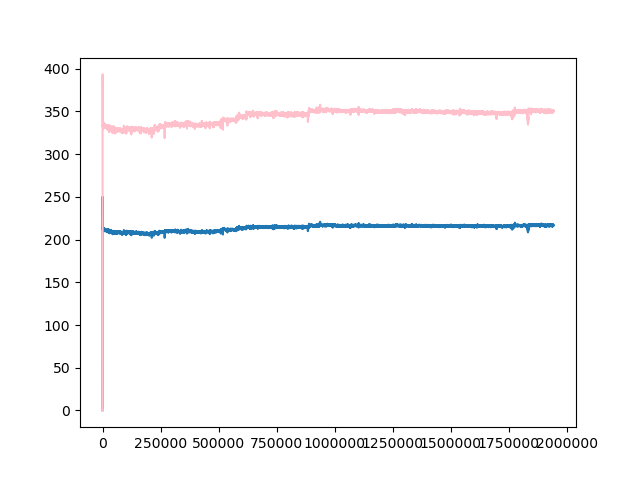

In [7]:
f, ax = plt.subplots()
ax.plot(x.data)
ax.plot(x.dataUV, 'pink');

### Helper functions for extracting data

In [8]:
calculate_lick_params(x)

Burst threshold set at 0.5 s
Parameters for left licks calculated...
Parameters for right licks calculated...


In [9]:
# Could alter this code to set colors for each bottle and maybe work out which is casein
x.left['color'] = 'green'
x.right['color'] = 'blue'

<IPython.core.display.Javascript object>


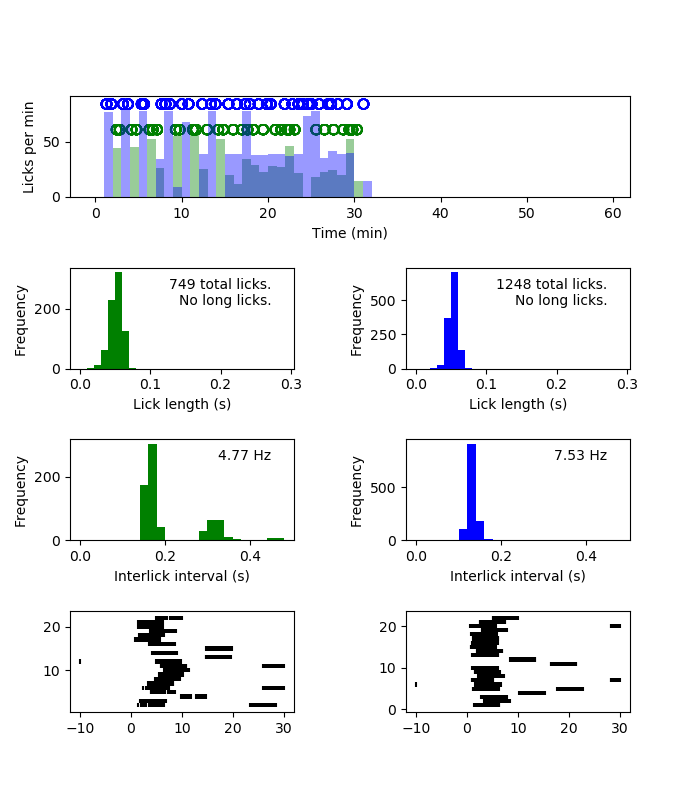

In [10]:
behavFig = plt.figure(figsize=(7,8))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(left=0.10, right= 0.9, wspace=0.5, hspace = 0.7)

ax = plt.subplot(gs1[0, :])
sessionlicksFig(ax)

if x.left['exist'] == True:
    behavFigsCol(gs1, 0, x.left)

if x.right['exist'] == True:
    behavFigsCol(gs1, 1, x.right)

# ax = plt.subplot(gs1[4, 0])
# jmfig.latencyFig(ax, x)

In [11]:
bins = 300

make_snips(x, bins=bins)

Number of bins=300
Random events and background trials constructed (used for working out noise)
No latency events found
No latency events found
No latency events found
No latency events found
Snips made successfully (I think).


<IPython.core.display.Javascript object>


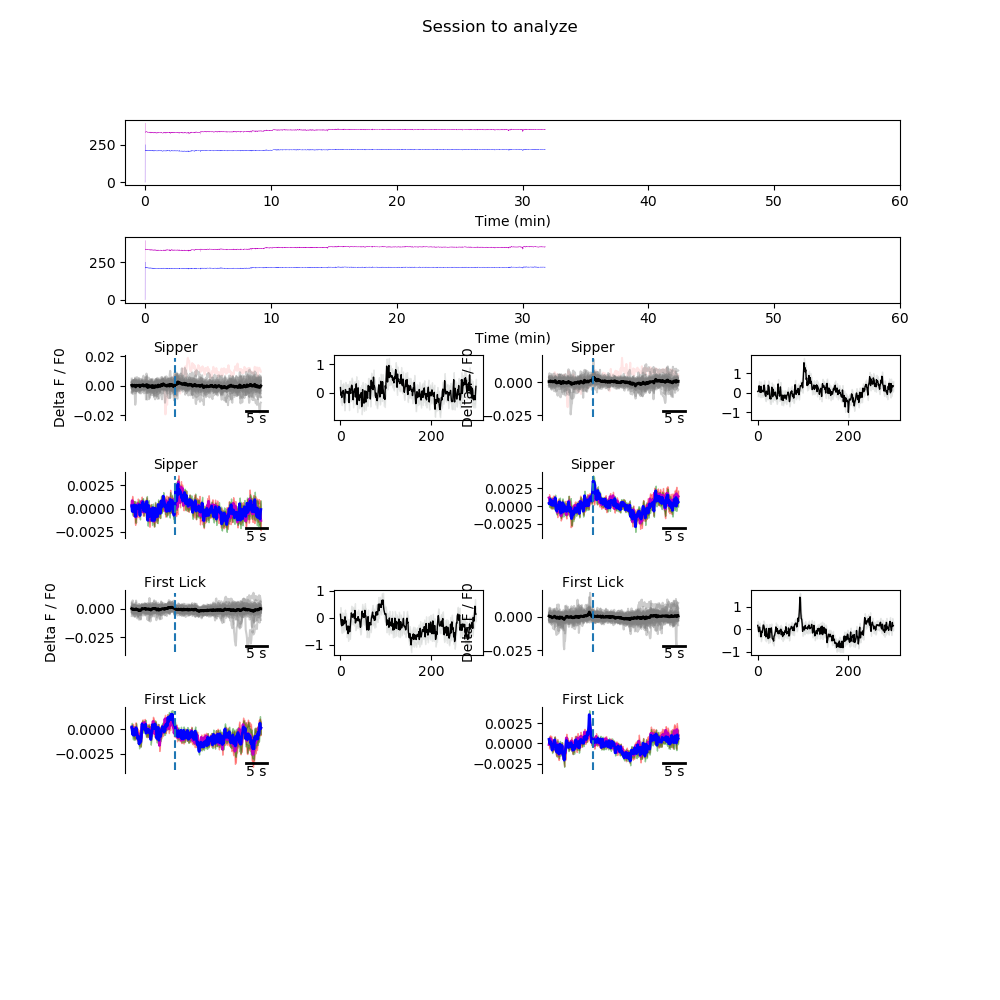

In [12]:
photoFig = plt.figure(figsize=(10, 10), dpi=100)
gs1 = gridspec.GridSpec(7, 4)
gs1.update(left=0.125, right= 0.9, wspace=0.4, hspace = 0.8)
plt.suptitle(x.sessionID)

ax = plt.subplot(gs1[0, :])
sessionFig(x, ax)

ax = plt.subplot(gs1[1, :])
sessionFig(x, ax)

if x.left['exist'] == True:
    photoFigsCol(gs1, 0, x.pps,
                 x.left['snips_sipper'],
                 x.left['snips_licks'])

if x.right['exist'] == True:
    photoFigsCol(gs1, 2, x.pps,
                 x.right['snips_sipper'],
                 x.right['snips_licks'])

# if x.left['exist'] == True and x.right['exist'] == True:
#     ax = plt.subplot(gs1[6, 0])
#     jmfig.trialsMultShadedFig(ax, [x.left['snips_sipper']['diff'], x.right['snips_sipper']['diff']],
#                               x.pps,
#                               linecolor=[x.left['color'], x.right['color']],
#                               eventText = 'Sipper')

#     ax = plt.subplot(gs1[6, 2])
#     jmfig.trialsMultShadedFig(ax, [x.left['snips_licks']['diff'], x.right['snips_licks']['diff']],
#                               x.pps,
#                               linecolor=[x.left['color'], x.right['color']],
#                               eventText = 'Lick')

In [13]:
# for i in np.arange(len(x.left['sipper'])):
#     print('Trial ', i)
#     blue = x.left['snips_sipper']['blue'][i]
#     uv = x.left['snips_sipper']['uv'][i]

#     f, ax = plt.subplots()
#     ax.plot(blue, c='blue')
#     ax.plot(uv, c='pink')
#     ax.set_ylim([-0.03, 0.03])

In [13]:
# for i in np.arange(len(x.left['sipper'])):
#     print('Trial ', i)
#     blue = x.left['snips_sipper']['blue'][i]
#     uv = x.left['snips_sipper']['uv'][i]
#     diff = x.left['snips_sipper']['diff'][i]

#     f, ax = plt.subplots()
#     ax.plot(diff, c='black')
#     ax.plot(uv, c='pink')
#     ax.set_ylim([-0.03, 0.03])

In [14]:
# avg = np.mean(x.left['snips_sipper']['diff'], axis=0)
# len(avg)

# f, ax = plt.subplots()
# ax.plot(avg, c='black')

In [15]:
# x.left['snips_sipper'].keys()

AxesSubplot(0.125,0.536818;0.352273x0.343182)
AxesSubplot(0.547727,0.536818;0.352273x0.343182)


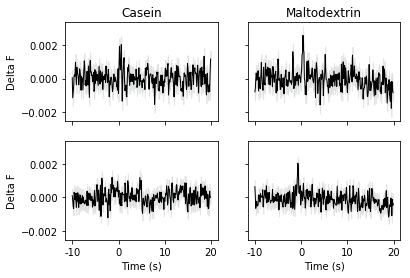

In [16]:
%matplotlib inline

f, ax = plt.subplots(nrows=2, ncols=2, sharey=True)
if x.left['exist']:
    jmfig.shadedError(ax[0][0], x.left['snips_sipper']['diff'])
    jmfig.shadedError(ax[1][0], x.left['snips_licks']['diff'])
    
if x.right['exist']:
    jmfig.shadedError(ax[0][1], x.right['snips_sipper']['diff'])
    jmfig.shadedError(ax[1][1], x.right['snips_licks']['diff'])

ax[0][0].set_title('Casein')
ax[0][1].set_title('Maltodextrin')

ax[0][0].set_ylabel('Delta F')
ax[1][0].set_ylabel('Delta F')

for axis in [ax[1][0], ax[1][1]]:
    axis.set_xlabel('Time (s)')
    axis.set_xticklabels(['-20', '-10', '0', '10', '20'])

for axis in [ax[0][0], ax[0][1]]:
    print(axis)
    axis.set_xticklabels([])




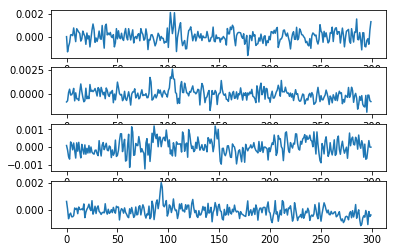

In [53]:
def getridofnoise(snips):
    trials_nonoise = [trial for trial, noise in zip(snips['diff'], snips['noise']) if not noise]
    return trials_nonoise

# These values need to be changed for each rat
savefolder = ''
rat = 'dpp1-1'
cas_side = 'left'


if cas_side == 'left':
    x.cas = x.left
    x.malt = x.right
else:
    x.cas = x.right
    x.malt = x.left

f, ax = plt.subplots(nrows=4)
    
file_suffix = ['_cas_sipper.txt', '_malt_sipper.txt', '_cas_licks.txt', '_malt_licks.txt']
    
for idx, snips in enumerate([x.cas['snips_sipper'], x.malt['snips_sipper'], x.cas['snips_licks'], x.malt['snips_licks']]):
    snips_nonoise = getridofnoise(snips)
    
    snips_avg = np.mean(snips_nonoise, axis=0)

    ax[idx].plot(snips_avg)
    
    np.savetxt(rat+file_suffix[idx], snips_avg)

In [43]:
x.cas.keys()

dict_keys(['exist', 'sipper', 'sipper_off', 'licks', 'licks_off', 'licks-forced', 'licks-free', 'nlicks-forced', 'nlicks-free', 'lickdata', 'color', 'snips_sipper', 'snips_licks', 'snips_licks_forced', 'lats'])